In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class Flatten(tf.Module):
    def __init__(self, name=None):
        super().__init__(name)

    def __call__(self,inputs):
        # (batch, height, width, patchsize)
        return tf.reshape(inputs,shape=[inputs.shape[0],-1, inputs.shape[-1]])
        

In [4]:
class LinearProjection(tf.Module):
    def __init__(self, projecition_dim, name=None):
        super().__init__(name)
        self.dense = tf.keras.layers.Dense(units=projecition_dim,name=name)

    def __call__(self,inputs):
        # (batch, patchnum, patchsize)
        assert inputs.ndim==3, "input shape to the LinearProjecition is wrong"
        x = self.dense(inputs)
        return x

In [5]:
class AddPositionEmbs(tf.Module):
    # add learable 1D position embeding 

    def __init__(self, name=None):
        super().__init__(name)

    def __call__(self, inputs): 
        # (batch, patchnum+1, projection_dim)
        # print(inputs.shape)
        position_emb_shape = (1, inputs.shape[1], inputs.shape[2])
        self.position_emb = tf.Variable(
            initial_value=tf.random.normal(position_emb_shape),
            name='PositionEmbs',
            trainable=True
        )
        return inputs + self.position_emb # broadcasting

In [6]:
class AddDummy(tf.Module):
    # attach learnable parameter to inputs

    def __init__(self, name=None):
        super().__init__(name)

    def __call__(self, inputs):
        # (batch, patchnum, projection_dim)

        assert inputs.ndim == 3, "input shape to the AddDummy is wrong"
        dummy_shape = (1, 1, inputs.shape[2])
        self.dummy = tf.Variable(
            initial_value=tf.random.normal(dummy_shape),
            name = 'dummy_patch',
            trainable=True
        )
        
        dummy = tf.repeat(self.dummy,repeats=[inputs.shape[0]], axis=0)
        y = tf.concat([dummy,inputs], axis=1)
        return y

In [7]:
class PatchEmbedding(tf.Module):
    # 1. add dummy patch and project patches to projection dimension 
    # 2. attach position embeddings to each patches 
    # NOTE add extra learnable class embedding to dummy patch

    def __init__(self, projection_dim, name=None):
        super().__init__(name=name)
        self.flatten = Flatten(name=name+'_flattening')
        self.projection = LinearProjection(projecition_dim=projection_dim, name=name+'_linear_projection')
        self.add_dummy = AddDummy()
        self.add_posemb = AddPositionEmbs()

    def __call__(self, inputs):
        # (batch, height, width, patchsize)
        x = self.flatten(inputs)
        x = self.projection(x)
        x = self.add_dummy(x)
        x = self.add_posemb(x)

        return x # (batch, patchnum+1, patchsize)

In [124]:
data = tf.constant(np.arange(20).reshape(5, 2, 2) * 10, dtype=tf.float32)
noise = tf.random.normal(shape=[5,2,2],stddev=20)
data = noise+data
data

<tf.Tensor: shape=(5, 2, 2), dtype=float32, numpy=
array([[[ -0.42476523,   8.029542  ],
        [ 41.232414  ,   6.809023  ]],

       [[ 39.513515  ,  55.355705  ],
        [ 48.67237   ,  44.746834  ]],

       [[ 83.49648   ,  75.89939   ],
        [101.47449   , 114.71094   ]],

       [[119.910255  , 119.23215   ],
        [121.887856  , 176.67961   ]],

       [[124.84429   , 170.56232   ],
        [187.56752   , 172.61804   ]]], dtype=float32)>

In [111]:
n1 = tf.keras.layers.LayerNormalization(axis=0)
n1(data)[:,1,:]

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[-1.434181  , -1.4138632 ],
       [-0.69455564, -0.7045014 ],
       [ 0.02757359,  0.00374174],
       [ 0.69525576,  0.6906787 ],
       [ 1.4059069 ,  1.4239436 ]], dtype=float32)>

In [118]:
n2 = tf.keras.layers.LayerNormalization(axis=1)
n2(data)[0,:,:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-0.9999951 , -0.9999956 ],
       [ 0.9999952 ,  0.99999535]], dtype=float32)>

In [135]:
n3 = tf.keras.layers.LayerNormalization(axis=2)
print(n3(data)[:,0,:])
print(n3(data)[:,1,:])

tf.Tensor(
[[-0.999972    0.999972  ]
 [-0.9999917   0.99999243]
 [ 0.9999648  -0.9999659 ]
 [ 0.99567866 -0.9956788 ]
 [-0.9999993   0.99999887]], shape=(5, 2), dtype=float32)
tf.Tensor(
[[ 0.99999833 -0.99999815]
 [ 0.9998695  -0.99987096]
 [-0.99998856  0.99998873]
 [-0.9999994   0.9999992 ]
 [ 0.999992   -0.9999902 ]], shape=(5, 2), dtype=float32)


In [8]:
class MLP(tf.Module):
    # MLP layer for transformer encoder
    # two layers with a GELU non-linearity

    # dense-gelu-dropout-dense-dropout
    def __init__(self, mlp_dim, output_dim, dropout_rate, name):
        super().__init__(name=name)
        self.mlp_dim = mlp_dim
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate

        self.dense_1 = tf.keras.layers.Dense(
            mlp_dim, 
            kernel_initializer = tf.keras.initializers.GlorotNormal(),
            bias_initializer = tf.keras.initializers.RandomNormal(stddev=1e-6), 
            activation=tf.nn.gelu, 
            trainable=True,
            name=name+'_dense1'
        )
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate, name=name+'_dropout')
        self.dense_2 = tf.keras.layers.Dense(
            output_dim, 
            kernel_initializer = tf.keras.initializers.GlorotNormal(),
            bias_initializer = tf.keras.initializers.RandomNormal(stddev=1e-6), 
            activation=tf.nn.gelu, 
            trainable=True,
            name=name+'_dense2'
        )
            # kernel은 xavier uniform/ bias는 normal(stddev=1e-6)
            # TODO check activaiton GELU's location 

    def __call__(self, inputs):
        y = self.dense_1(inputs)
        y = self.dense_2(y)
        return y

In [16]:
MLP_DIM = 100
DROPOUT_RATE = 0.7
ATTENTION_DROPOUT_RATE = 0.9
# ATTENTION_HIDDEN_DIM
# ATTENTION_OUTPUT_DIM
# TODO 매개변수 편하게 표현할 방법

In [9]:
class EncoderBlock(tf.Module):
    # Layer Norm / MHA+dropout / skip-connection / Layer Norm/ MLP / skip-connection

    def __init__(self, projection_dim, name=None):
        super().__init__(name)
        self.layer_norm = tf.keras.layers.LayerNormalization(axis=0, name=name+'_layer_norm')
        self.MHA = tf.keras.layers.MultiHeadAttention(
            num_heads=1,
            key_dim=50,
            value_dim=100,
            dropout=ATTENTION_DROPOUT_RATE,
            use_bias=False,
            #output_shape=(-1,input_shape[1],self.hidden_dim),
            attention_axes=(1,2),

            kernel_initializer=tf.keras.initializers.GlorotNormal(),
            trainable=True,
            name=name+'_MHA'
        )
        self.dropout = tf.keras.layers.Dropout(DROPOUT_RATE,name=name+'_dropout')
        self.MLP = MLP(
            mlp_dim=MLP_DIM, 
            output_dim=projection_dim, 
            dropout_rate=DROPOUT_RATE, 
            name=name+'_encoder_mlp'
        )
        # TODO check the value of mlpdim and dropout_rate

    def __call__(self, inputs):
        x1 = self.layer_norm(inputs)
        x1 = self.MHA(x1,x1)
        x1 = self.dropout(x1)
        skip2 = x1 + inputs
        x2 = self.layer_norm(skip2)
        x2 = self.MLP(x2)
        outputs = x2+skip2

        return outputs

In [10]:
class Encoder(tf.Module):

    def __init__(self, block_num, projection_dim, name=None):
        super().__init__(name)
        self.block_num = block_num
        self.patch_embedding = PatchEmbedding(projection_dim=projection_dim, name='patch_embs')
        self.encoder_block = EncoderBlock(projection_dim=projection_dim, name='encoder_block')
        self.encoder_norm = tf.keras.layers.LayerNormalization(axis=0, name='encoder_norm')

    def __call__(self, inputs):
        self.emb = self.patch_embedding(inputs)
        for i in range(self.block_num):
            self.encoded = self.encoder_block(self.emb)

        # self.encoded_norm = self.encoder_norm(self.encoded)
        '''
        TODO check encoder norm is needed.
        encoded_norm makes the final result all zero.
        '''
        
        return self.encoded

In [14]:
class VisionTransformer(tf.Module):
    def __init__(self, patch_size,block_num, projection_dim, class_num, name=None):
        super().__init__(name)
        self.patch_size = patch_size
        self.class_num = class_num
        self.encoder = Encoder(block_num = block_num, projection_dim=projection_dim)
        self.classifier = tf.keras.layers.Dense(class_num, name='classifier')
        self.softmax = tf.keras.layers.Softmax()

    def __call__(self, inputs):
        # (batch, height, width)
        patches = tf.image.extract_patches(
            inputs,
            sizes=[1,self.patch_size,self.patch_size,1], 
            strides=[1,self.patch_size,self.patch_size,1],
            rates=[1,1,1,1],
            padding='VALID'
        )
        if inputs.shape[0] == 1:
            # batch가 아닌 1개의 이미지가 들어온 경우
            # 배치 개수만큼 늘려주자
            patches = tf.repeat(input=patches, repeats=[inputs.shape[0]], axis=0)
            
        encoded = self.encoder(patches)
        self.class_token = encoded[:,0,:]
        if len(self.class_token.shape) == 3:
            self.class_token = tf.squeeze(self.class_token, axis=1)

        outputs = self.classifier(self.class_token)
        outputs = self.softmax(outputs)

        return outputs

### 모델 동작 확인

In [45]:
from PIL import Image
import numpy as np
from io import BytesIO
import requests

def preprocess_image(image):
    image = np.array(image)
    image_resized = tf.image.resize(image, (32, 32))
    image_resized = tf.cast(image_resized, tf.float32)
    image_resized = (image_resized - 127.5) / 127.5
    return tf.expand_dims(image_resized, 0).numpy()

def load_image_from_url(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    image = preprocess_image(image)
    return image

img_url = "https://p0.pikrepo.com/preview/853/907/close-up-photo-of-gray-elephant.jpg"
image = load_image_from_url(img_url)

In [63]:
self.patch_size = 16

resized_image = tf.image.resize(image, [64,32])
images = tf.repeat(image,[100], axis=0)
patches = tf.image.extract_patches(images, 
                    sizes=[1,self.patch_size,self.patch_size,1], 
                    strides=[1,self.patch_size,self.patch_size,1],
                    rates=[1,1,1,1],
                    padding='VALID'
                )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


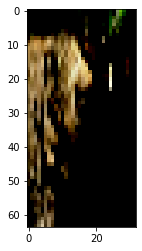

In [57]:
plt.imshow(resized_image[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


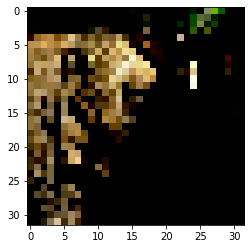

In [50]:
plt.imshow(image[0])

In [72]:
patches.shape

TensorShape([100, 2, 2, 768])

In [74]:
p = PatchEmbedding(projection_dim=100)
p(patches).shape

TensorShape([100, 5, 100])

In [155]:
patches.shape

TensorShape([100, 2, 2, 768])

In [202]:
e = Encoder(projection_dim=100, name='encoder')
e(patches, block_num=1).shape

TensorShape([100, 5, 100])

In [199]:
len(e.trainable_variables)
# MHA - 4
# MLP - 2*2
# LM in MLP - 2
# LM in encoder - 2
# dummy - 1
# posemb - 1
# linear projection - 2

16

In [253]:
[1]*10

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [256]:
images = tf.stack([image]*10)
images = tf.squeeze(images)

In [262]:
vit = VisionTransformer(patch_size=16, block_num=1, projection_dim=20, class_num=1000)
vit(images)

<tf.Tensor: shape=(10, 1000), dtype=float32, numpy=
array([[0.00099019, 0.00132887, 0.00110782, ..., 0.00078618, 0.00091062,
        0.00100394],
       [0.00099019, 0.00132887, 0.00110782, ..., 0.00078618, 0.00091062,
        0.00100394],
       [0.00099019, 0.00132887, 0.00110782, ..., 0.00078618, 0.00091062,
        0.00100394],
       ...,
       [0.00099019, 0.00132887, 0.00110782, ..., 0.00078618, 0.00091062,
        0.00100394],
       [0.00099019, 0.00132887, 0.00110782, ..., 0.00078618, 0.00091062,
        0.00100394],
       [0.00099019, 0.00132887, 0.00110782, ..., 0.00078618, 0.00091062,
        0.00100394]], dtype=float32)>

### 모델 훈련

In [17]:
vit = VisionTransformer(patch_size=16, block_num=1, projection_dim=20, class_num=1000)

In [18]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")



x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [25]:
y_test_sample = tf.keras.utils.to_categorical(y_test[:10], 1000)
y_train_sample = tf.keras.utils.to_categorical(y_test[:10], 1000)

In [26]:
x_train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
y_train_dataset = tf.data.Dataset.from_tensor_slices(y_train)
x_test_dataset = tf.data.Dataset.from_tensor_slices(x_test)
y_test_dataset = tf.data.Dataset.from_tensor_slices(y_test)
train_dataset = tf.data.Dataset.zip((x_train_dataset, y_train_dataset))
test_dataset = tf.data.Dataset.zip((x_test_dataset, y_test_dataset))

train_batch = train_dataset.batch(100)
test_batch = test_dataset.batch(100)

In [27]:
cce = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

In [28]:

# TODO make training code faster
# Given a callable model, inputs, outputs, and a learning rate...
def train(model, x, y):

  with tf.GradientTape() as tape:
    # Trainable variables are automatically tracked by 
    y = tf.keras.utils.to_categorical(y,1000)
    y_ = model(x)
    current_loss = cce(y, y_)

  # Use GradientTape to calculate the gradients with respect to parameters in model
  gradients = tape.gradient(current_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  # Subtract the gradient scaled by the learning rate
  # model.w.assign_sub(learning_rate * dw)
  # model.b.assign_sub(learning_rate * db)
  return current_loss

In [29]:
epochs = 100
# Define a training loop
def training_loop(model, batch):

  for epoch in range(epochs):
    # Update the model with the single giant batch
    for step, (x_batch, y_batch) in enumerate(batch):
      minibatch_loss = train(model, x_batch, y_batch)

    # Track this before I update
    # Ws.append(model.w.numpy())
    # bs.append(model.b.numpy())

    print("Epoch %2d: loss=%2.5f" % (epoch, minibatch_loss))

In [30]:
training_loop(vit, train_batch)

2022-11-15 19:25:58.088776: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-15 19:25:58.122016: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch  0: loss=6.91923
Epoch  1: loss=6.91296
Epoch  2: loss=7.00701
Epoch  3: loss=6.94552
Epoch  4: loss=6.90667
Epoch  5: loss=6.95655
Epoch  6: loss=6.91465
Epoch  7: loss=6.91146
Epoch  8: loss=6.81367
Epoch  9: loss=6.78720
Epoch 10: loss=6.70989
Epoch 11: loss=6.74984
Epoch 12: loss=6.64445
Epoch 13: loss=6.82197
Epoch 14: loss=6.61170
Epoch 15: loss=6.62758
Epoch 16: loss=6.61216
Epoch 17: loss=6.62161
Epoch 18: loss=6.19454
Epoch 19: loss=6.26049
Epoch 20: loss=6.28317
Epoch 21: loss=6.06780
Epoch 22: loss=5.85774
Epoch 23: loss=5.68926
Epoch 24: loss=5.57079
Epoch 25: loss=5.17103
Epoch 26: loss=5.26013
Epoch 27: loss=5.22982
Epoch 28: loss=5.11142
Epoch 29: loss=5.01365
Epoch 30: loss=4.69790
Epoch 31: loss=4.83433
Epoch 32: loss=4.67190
Epoch 33: loss=4.63691
Epoch 34: loss=4.52287
Epoch 35: loss=4.61028
Epoch 36: loss=4.44076
Epoch 37: loss=4.41658
Epoch 38: loss=4.46938
Epoch 39: loss=4.51879
Epoch 40: loss=4.44682
Epoch 41: loss=4.36723
Epoch 42: loss=4.36634
Epoch 43: l

### 훈련후 확인

In [35]:
vit.submodules[0].

### 이미지 제너레이터

In [305]:
import os
import pandas as pd
import csv

In [306]:
def loadCSVData(path, rootpath):

    filecsv   = open(path)
    csvreader = csv.reader(filecsv)
    rows = []
    
    header = []
    header = next(csvreader)
    
    for row in csvreader:
        try:

            impath =  "{}/{}jpg".format(rootpath, row[0])
        
            new_row = {'elevation':float(row[1]),
                    'azimuth': float(row[2]),
                    'impath':impath}
            
            rows.append(new_row)
            
        except Exception as e:
            print(e)
    
    return rows 

In [ ]:
train_csvpath = os.path.join(root_data,"train_listed.csv")
train_datapath = os.path.join(root_data,"ldr_train/")
train_rows = loadCSVData(train_csvpath,train_datapath)
print("train_rows:",len(train_rows))

train_df = pd.DataFrame.from_records(train_rows)
train_df = train_df.sample(frac=1.0,  random_state=1)
train_df = train_df.reset_index(drop=True)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
train_images  = train_generator.flow_from_dataframe(
    dataframe =  train_df,
    x_col = 'impath',
    y_col = ['elevation', 'azimuth'],
    target_size = input_shape[:2],
    #target_size = (120,120),
    #color_mode='grayscale',
    color_mode='rgb',
    class_mode = 'raw',
    batch_size =BATCH_SIZE,
    shuffle=False,
    seed=SEED,
    subset='training'
)
val_images  = train_generator.flow_from_dataframe(
    dataframe =  train_df,
    x_col = 'impath',
    y_col = ['elevation', 'azimuth'],
    target_size = input_shape[:2],
    #target_size = (120,120),
    #color_mode='grayscale',
    color_mode='rgb',
    class_mode = 'raw',
    batch_size =BATCH_SIZE,
    shuffle=False,
    seed=SEED,
    subset='validation'
)

print(root_data)
test_csvpath  =  os.path.join(root_data,"val_listed.csv")
test_datapath =  os.path.join(root_data,"ldr_val/")
test_rows = loadCSVData(test_csvpath, test_datapath)

test_df = pd.DataFrame.from_records(test_rows)
# test_df = test_df.sample(frac=1.0,  random_state=1)
# test_df = test_df.reset_index(drop=True)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
test_images  = test_generator.flow_from_dataframe(
    dataframe =  test_df,
    x_col = 'impath',
    y_col = ['elevation', 'azimuth'],
    target_size = (256,1024),
    #target_size = (500,500),
    #target_size = (120,120),
    #color_mode='grayscale',
    color_mode='rgb',
    class_mode = 'raw',
    batch_size =BATCH_SIZE,
    shuffle=False
)
test_labels = test_images.labels

train_rows: 28796
Found 18448 validated image filenames.
Found 4612 validated image filenames.
/home/cvnar1/Desktop/teamHDR/data
Found 4043 validated image filenames.


/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 5736 invalid image filename(s) in x_col="impath". These filename(s) will be ignored.
  warnings.warn(
/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 5736 invalid image filename(s) in x_col="impath". These filename(s) will be ignored.
  warnings.warn(
/home/cvnar1/anaconda3/envs/tensorflow2.8/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 3155 invalid image filename(s) in x_col="impath". These filename(s) will be ignored.
  warnings.warn(


In [303]:
training_loop(vit, x_test, y_test)

InvalidArgumentError: Exception encountered when calling layer "encoder_block_layer_norm" (type LayerNormalization).

Input to reshape is a tensor with 10 values, but the requested shape has 10000 [Op:Reshape]

Call arguments received:
  • inputs=tf.Tensor(shape=(10000, 5, 20), dtype=float32)